MATCHING DAYS: 4

Matched data:
  sleep_night_date  avg_temperature  sleep_latency_minutes
0       2025-10-29        21.330000                     45
1       2025-10-30        21.675000                     45
2       2025-11-04        22.000000                     15
3       2025-11-08        20.905882                     15


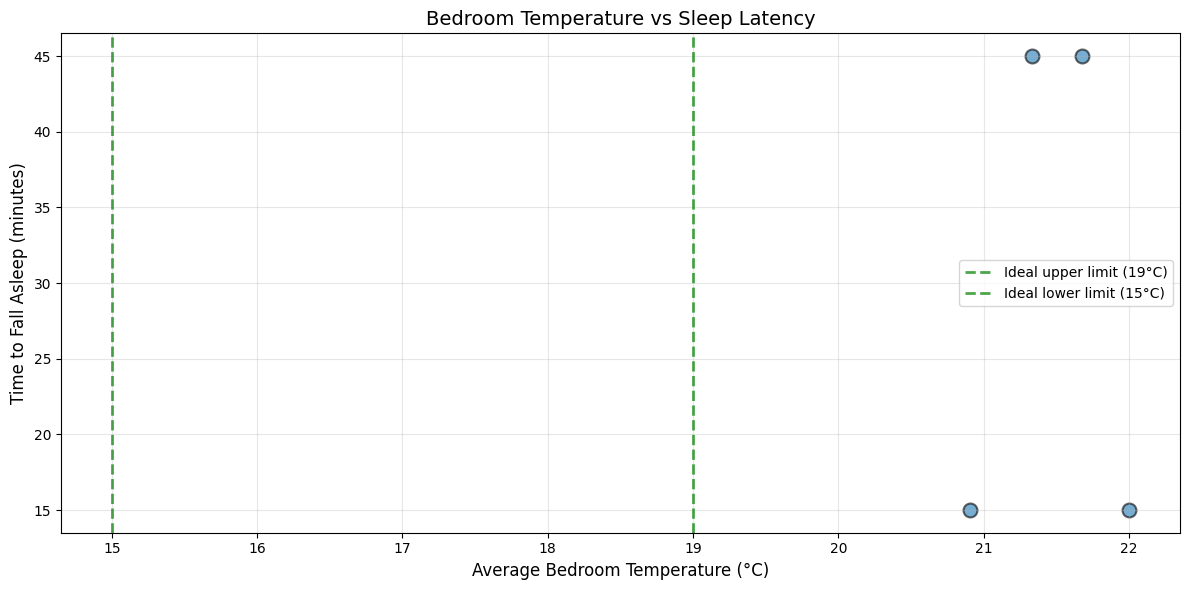


Average temperature: 21.48°C
Average sleep latency: 30.00 minutes


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta

# Load both datasets
devices_df = pd.read_csv('devices-data.csv')
survey_df = pd.read_csv('survey-responses.csv')

# Process devices data (Arduino sensor)
devices_df['created_at'] = pd.to_datetime(devices_df['created_at'])
# Adjust for 1 hour timezone difference
devices_df['created_at'] = devices_df['created_at'] + timedelta(hours=1)
devices_df['date'] = devices_df['created_at'].dt.date
devices_df['time'] = devices_df['created_at'].dt.time

# Filter data between 21:00 and 02:00 (sleep window)
def is_in_sleep_window(time_obj):
    """Check if time is between 21:00 and 02:00"""
    if time_obj >= time(21, 0) or time_obj <= time(2, 0):
        return True
    return False

devices_df['in_sleep_window'] = devices_df['time'].apply(is_in_sleep_window)
sleep_window_data = devices_df[devices_df['in_sleep_window']].copy()

# Calculate average temperature per date during sleep window
daily_avg_temp = sleep_window_data.groupby('date')['temperature'].mean().reset_index()
daily_avg_temp.columns = ['date', 'avg_temperature']

# Process survey data
def time_to_minutes(time_str):
    if pd.isna(time_str) or time_str == 'X':
        return np.nan
    try:
        time_str = str(time_str).strip()
        time_obj = pd.to_datetime(time_str, format='%H:%M:%S').time()
        total_minutes = time_obj.hour * 60 + time_obj.minute
        return total_minutes
    except:
        return np.nan

survey_df['sleep_latency_minutes'] = survey_df['How long did it take you to fall asleep?'].apply(time_to_minutes)
survey_df['Timestamp'] = pd.to_datetime(survey_df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
survey_df['survey_date'] = survey_df['Timestamp'].dt.date

# The survey reports on the PREVIOUS night, so we need to subtract 1 day
survey_df['sleep_night_date'] = survey_df['Timestamp'].dt.date
survey_df['sleep_night_date'] = pd.to_datetime(survey_df['sleep_night_date']) - timedelta(days=1)
survey_df['sleep_night_date'] = survey_df['sleep_night_date'].dt.date

# Merge on the sleep night date
merged_df = pd.merge(survey_df[['sleep_night_date', 'sleep_latency_minutes']],
                     daily_avg_temp,
                     left_on='sleep_night_date',
                     right_on='date',
                     how='inner')

# Remove rows with missing data
merged_df = merged_df.dropna()

print(f"{'='*60}")
print(f"MATCHING DAYS: {len(merged_df)}")
print(f"{'='*60}")
print("\nMatched data:")
print(merged_df[['sleep_night_date', 'avg_temperature', 'sleep_latency_minutes']])

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['avg_temperature'], merged_df['sleep_latency_minutes'],
            s=100, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add reference line for ideal temperature range
plt.axvline(x=19, color='green', linestyle='--', linewidth=2,
            label='Ideal upper limit (19°C)', alpha=0.7)
plt.axvline(x=15, color='green', linestyle='--', linewidth=2,
            label='Ideal lower limit (15°C)', alpha=0.7)

plt.xlabel('Average Bedroom Temperature (°C)', fontsize=12)
plt.ylabel('Time to Fall Asleep (minutes)', fontsize=12)
plt.title('Bedroom Temperature vs Sleep Latency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig('temperature_vs_sleep_latency.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage temperature: {merged_df['avg_temperature'].mean():.2f}°C")
print(f"Average sleep latency: {merged_df['sleep_latency_minutes'].mean():.2f} minutes")
print("="*60)